## Info
Setting up the model to receate the hydrosynamics of the Solitary Wave model from BarSed.

Author: WaveHello

Date: 07/15/2024

### Notes
ADV data and pressure data for the solitary wave cases aren't in the folders I downloaded. I'm not sure where that data is or if it was recorded.

In [2]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
import pandas as pd
from scipy import special

# Set global constants
PI = np.pi
G = 9.81

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

**no xbTools installation found in environment, adding parent path of notebook to see if it works


In [3]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"..\..\..\BarSed_Lib")

# Import the library modules

from lib.data_classes.Run import Run

In [4]:
from xbTools.grid.creation import xgrid
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script


In [5]:
# Fuctions
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

def create_directory_if_not_exists(directory_path):
    """
    Creates a directory if it does not already exist.
    
    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

def moving_average_filter(data, window_size):
    """
    Applies a moving average filter to the input data.

    Parameters:
    - data: The input array of data points (list or numpy array).
    - window_size: The size of the moving window.

    Returns:
    - filtered_data: The filtered data as a numpy array.
    """
    # Convert data to a numpy array if it is not already
    data = np.array(data)
    
    # Ensure the window size is an integer
    window_size = int(window_size)
    
    # Check if window size is greater than 0 and less than or equal to the length of data
    if window_size <= 0 or window_size > len(data):
        raise ValueError("Window size must be greater than 0 and less than or equal to the length of the data.")
    
    # Compute the moving average using np.convolve with 'valid' mode to avoid padding effects
    filtered_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    return filtered_data

### Set the information for the selected Run

In [6]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"D:\ERDC\BarSed_Data"

# Set the information needed for specifying the run
# Run number
run_number = "001"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)


### Set data that isn't directly available in the inputs

### Get the bathymetry for the model

In [7]:
# Name of the bathy data binary
bathy_file_name = r"bathy.mat"

# Path to where I'm storing the bathymetry data
bathy_file_path = os.path.join(barsed_data_path, bathy_file_name)

print(f"Bathy file path: {bathy_file_path}")

Bathy file path: D:\ERDC\BarSed_Data\bathy.mat


### Get the path to the wave gauge data

In [8]:

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the bathymetry data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

print(f"Run{run_number} wave mat file path: {wave_data_path}")

Run001 wave mat file path: D:\ERDC\BarSed_Data\WG\RUN001.mat


### Get the path to the adv data
The period of the wave maker is stored in this data. Not using it for anything else at the momement.

In [9]:
# Name of the folder containing the adv data
ADV_data_folder_name = r"ADV"

# Path to where the velocity data is being stored
ADV_data_path = os.path.join(barsed_data_path, ADV_data_folder_name)

# Path to the adv data for the selected run
ADV_file_path = os.path.join(ADV_data_path, run_name)

print(f"{ADV_data_folder_name} file path: {ADV_data_path}")
print("{} Data for mat file path: {}".format(ADV_data_folder_name, ADV_file_path))

ADV file path: D:\ERDC\BarSed_Data\ADV
ADV Data for mat file path: D:\ERDC\BarSed_Data\ADV\RUN001.mat


### Collect the bathymetry data

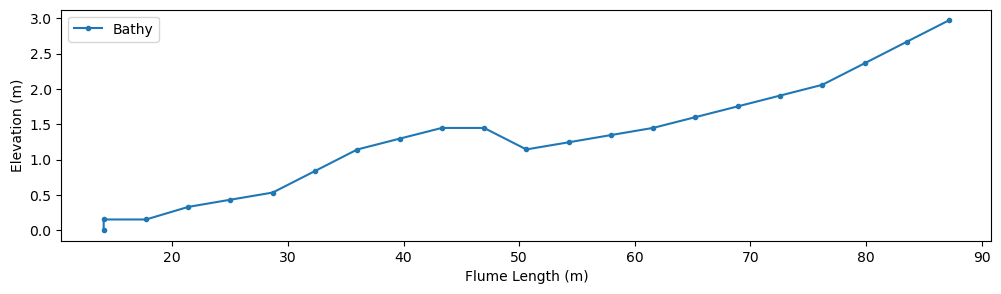

In [10]:
# Make a plot of the bathymetry to make sure the data is right
# Load the .mat file
bathy_dict = scipy.io.loadmat(bathy_file_path)

# Get the bathymetry data
bathy_df = pd.DataFrame(bathy_dict["bathy"], columns = ["x_loc", "z_loc"])

bathy_df.plot("x_loc", "z_loc", marker = ".", 
              figsize = (12, 3), label = "Bathy", 
              ylabel= "Elevation (m)", xlabel = "Flume Length (m)"
)

plt.legend()
plt.show()

### Construct the Run object
This object will help organize the data and help store the data

In [11]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_file_path)

print(Run_data)


id: RUN001
Start Date: None
Wave Data File path: D:\ERDC\BarSed_Data\WG\RUN001.mat
Num pressure gagues: None
Num advs: None


### Collect the wave gauge data

New Number of 17 wave gauges
Wave Maker information:
Number of times: 20863


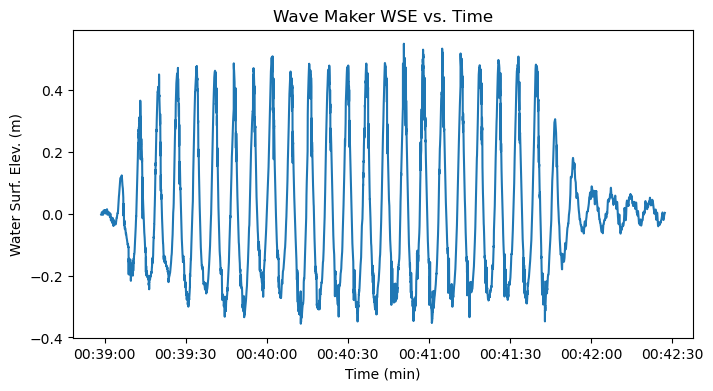

In [12]:
Run_data.load_wave_data()

print(Run_data.wave_maker)

Run_data.wave_maker.quick_wse_plot()

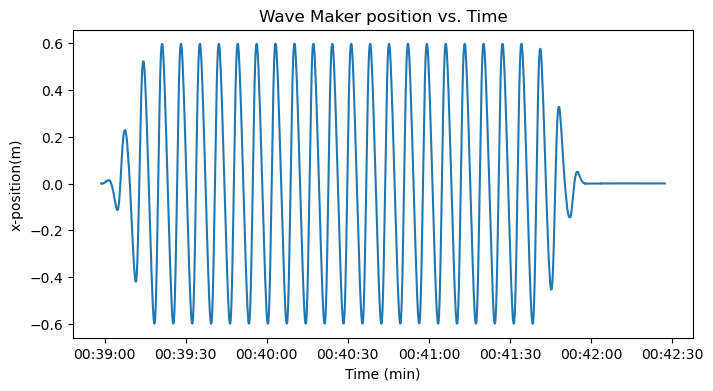

In [13]:
Run_data.wave_maker.quick_position_plot()

## Smoothing the surface data

In [14]:
# Convert the wave maker date_time to time in seconds
first_time = Run_data.wave_maker.date_time[0]

seconds_from_first = np.array([(dt - first_time).total_seconds() for dt in Run_data.wave_maker.date_time])


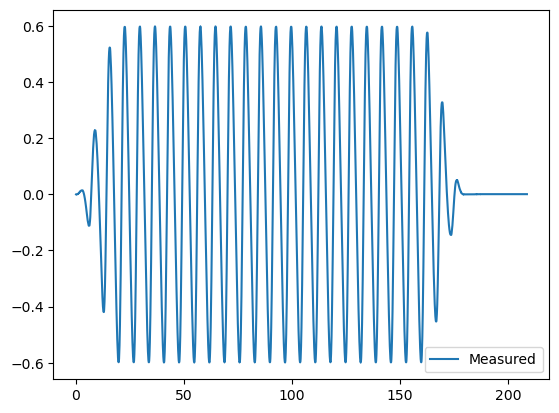

In [15]:
# Plot the wave maker location as a function of time in seconds

fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs = np.atleast_1d(axs)

shift = 10
wave_maker_loc = Run_data.wave_maker.position
axs[0].plot(seconds_from_first, wave_maker_loc, label = "Measured")

plt.legend()
plt.show()

## Generating the xBeach inputs

### Generating the Bathymetry

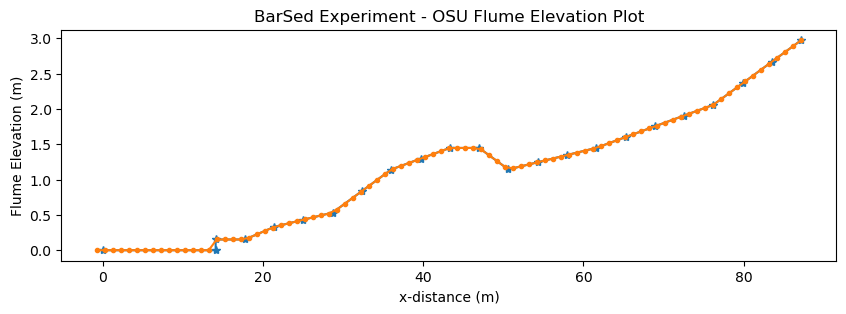

In [16]:
# Reinterpolate the raw bathymetry for the xBeach model

x = np.array(bathy_df["x_loc"])
z = np.array(bathy_df["z_loc"])

# Add the zero to the arrays
x = np.concatenate(([0.0], x))
z = np.concatenate(([0.0], z))

# x_zero = np.array(0, )
xgr, zgr = xgrid(x, z, dxmax = 0.1, dxmin = 1)


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

# Convert axs to an array so I can iterate over it if needed
axs = np.atleast_1d(axs)

axs[0].plot(x, z    , marker = "*", label = "Bathy")
axs[0].plot(xgr, zgr, marker = ".", label = "xgr")
# axs[0].axhline(y = 3.0)
axs[0].set_xlabel("x-distance (m)")
axs[0].set_ylabel("Flume Elevation (m)")

plt.title("BarSed Experiment - OSU Flume Elevation Plot")
plt.show()
#TODO: Need to look into what the proper procedure for 


### Generating the wave data

In [17]:
print(Run_data)

id: RUN001
Start Date: 2015-01-22
Wave Data File path: D:\ERDC\BarSed_Data\WG\RUN001.mat
Num pressure gagues: None
Num advs: None


In [18]:
print(Run_data.wave_gauges[0])

Wave Gauge Type: self_calibrating
Gauge Id: 1
Location: (17.728, -1.269)


Water surface elevation: 2.971 [m]


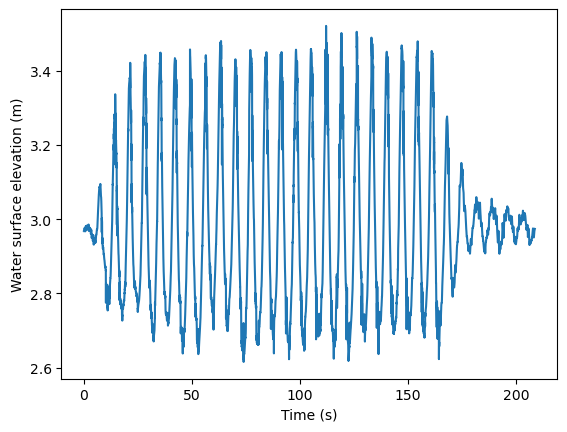

In [19]:
# Set information
zs0 = zgr.max()

# Offset the water suface elevation from the bottom
eta = zs0 + Run_data.wave_maker.eta_wm
# Generate the wave boundary condition

# Calc the velocity of the

print(f"Water surface elevation: {zs0} [m]")
plt.plot(seconds_from_first, eta)
plt.xlabel("Time (s)")
plt.ylabel("Water surface elevation (m)")
plt.show()

### Generating the computational params for the model

In [20]:
xb_setup = XBeachModelSetup('Rand_vel_v1_1')

xb_setup.set_grid(xgr, None, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

### Wave maker boundary conditon in the x-direction for one directional flow

From Dean and Dalrymple if $S(z, t)$ is the displacement of the wave maker. Wave maker is pined at the bottom and rotates about that point. Then 

$$x = S(z, t) $$

which means a surface, $F$ can be defined with

$$F = x - S(z, t) = 0$$

using the condtion that $$ \frac{DF}{Dt} = 0 $$ where $$ \frac{D \cdot}{Dt}$$ is the material derivative. Using this relation Dean and Dalrymple derive the relation that 

$$ u - w \frac{\partial S }{ \partial z } = \frac{\partial S}{ \partial t} |_{on  x = S(z,t)}$$

Given that I don't have the $w$ velocity and I need the $u$ velocity as an input to xbeach I'm going to assume that the wave maker doesn't make that big of an angle such that 

$$\frac{\partial S}{\partial z} \approx 0$$

and that 

$$ u = \frac{\partial S }{\partial t} = \frac{d S}{d t}$$


In [21]:
x0 = Run_data.wave_maker.position

# Calc the increment of displacement
# /delta S where S is the displacement
inc_displacement = x0[1:] - x0[:-1]

# Calc the time increment
inc_time = seconds_from_first[1:] - seconds_from_first[:-1]

# Calc the velocity = \delta S / /delta t, assuming that the slope \partial S
u = inc_displacement / inc_time 

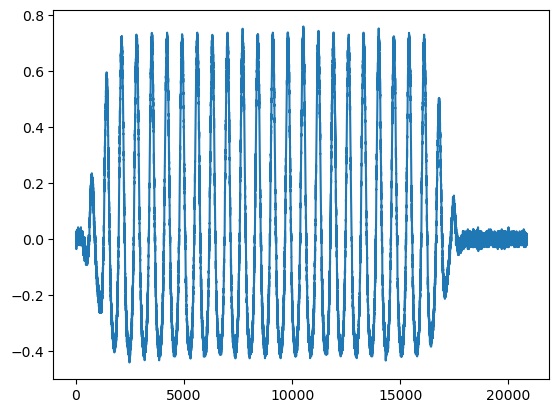

In [22]:
plt.plot(u)

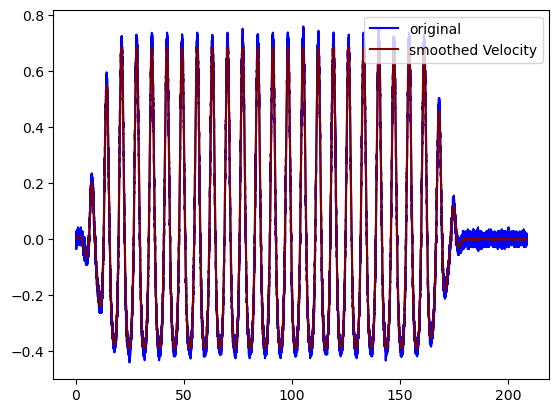

In [23]:
window_size = 75

# Get the time that corresponds to the veloctity
vel_time = seconds_from_first[1:]

smoothed_time = moving_average_filter(vel_time, window_size)
smoothed_u = moving_average_filter(u, window_size)

plt.plot(vel_time, u, color = "blue", label = "original")
plt.plot(smoothed_time, smoothed_u  , color = "maroon", label = "smoothed Velocity")
plt.legend()

In [24]:
# Need to also apply the filter to the surface pertubation 
# so that the array is the sam length as the velocity array 
smoothed_eta = moving_average_filter(eta, window_size)

In [25]:
print(len(smoothed_eta))
print(len(smoothed_time))
print(len(smoothed_u))

20789
20788
20788


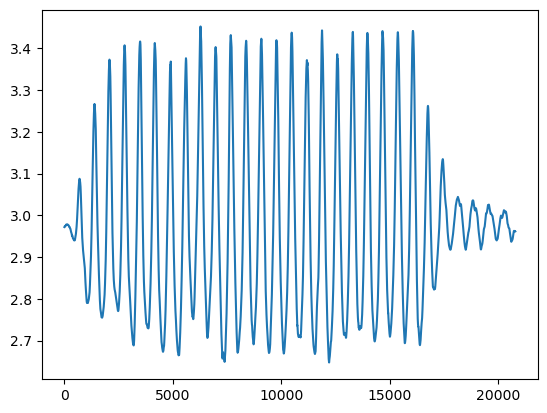

In [26]:
plt.plot(smoothed_eta)

In [27]:
# Addding a the initial values to offset from the smoothing

# Making the initial velocity zero
smoothed_u  = np.insert(smoothed_u, 0, 0.0)

# Making the initial surface elevation zs0
smoothed_eta[0] = zs0

# Make the initial time zreo
smoothed_time = np.insert(smoothed_time, 0, 0.0)

In [28]:
print(len(smoothed_eta))
print(len(smoothed_time))
print(len(smoothed_u))

20789
20789
20789


In [29]:

# Generate a random u velocity for the time being
u_avg = Run_data.wave_maker.position

zs_scaling = 1.0
u_scale = 1.0

# u_window = np.ones(len(u_window))

boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "scalar",
               "variable_dict": {
                   "t" : smoothed_time,
                   "zs": zs_scaling * (smoothed_eta - zs0), # Pertubation from the intial water surface
                   "U" : u_scale * smoothed_u, 
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)

print(f"WARNING: USING a zs scaling of {zs_scaling}. This doesn't make physical sense")


In [30]:
xb_setup.set_params({ "wbctype"     : "ts_nonh",
                    #  "taper"        : 0.0,
                     "wavemodel"    : "nonh",
                     "nonh"         : 1,
                     "CFL"          : 0.5,
                     "lateralwave"  : "neumann",
                     "zs0"          : zs0,
                     'bedfriccoef'  : 0.0,
                    #  "order"        : 2,
                    #  "ARC"          : 1,
                     "front"        : "nonh_1d", "back" : "abs_1d",
                     "left"         : "wall", "right": "wall",
                     "tstop"        : boun_U_dict["variable_dict"]["t"].max(),
                     "outputformat" : "netcdf",
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})

The following params were not found in the JSON: 
{'nonh': 1}


In [31]:
xb_setup.input_par

{'par': {'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh',
  'lateralwave': 'neumann'},
 'Physical processes': {'wavemodel': 'nonh'},
 'Model time': {'CFL': 0.5, 'tstop': 208.2500002266667},
 'Tide boundary conditions': {'zs0': 2.971},
 'Flow parameters': {'bedfriccoef': 0.0},
 'Flow boundary condition parameters': {'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'wall',
  'right': 'wall'},
 'Output': {'outputformat': 'netcdf',
  'tintm': 0.1,
  'tintp': 0.1,
  'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H', 'u', 'v']}}

### Generating the model files

In [32]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"..\..\..\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")


Directory 'c:\ERDC\BarSed_xBeach_models\Osillating_wave_models\Run_001\' already exists.


In [33]:
xb_setup.write_model(model_dir, num_dec_dig=10)

Data written to c:\ERDC\BarSed_xBeach_models\Osillating_wave_models\Run_001\boun_U.bcf


In [34]:
# Write the wave maker data to a txt file

# Time, location, wse
data = {"time"     : seconds_from_first,     
        "location" : Run_data.wave_maker.position,
        "wse"      : Run_data.wave_maker.eta_wm + zs0
        }
df = pd.DataFrame(data)
display(df)
df.to_csv("wave_maker.csv", index = False)

,time,location,wse
0,0.000000,-0.000015,2.968093
1,0.009998,0.000198,2.968093
2,0.019996,0.000056,2.968028
3,0.030004,0.000127,2.968157
4,0.040002,0.000056,2.968350
...,...,...,...
20858,208.579999,0.000340,2.973698
20859,208.590007,0.000410,2.973698
20860,208.599995,0.000340,2.973762
20861,208.610003,0.000410,2.973827
